## Get dataset to train

In [1]:
import json
import torch    #if error, restart kernel
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import glob
import pandas as pd

Fs = 100  # Sampling frequency

# Path to the folder containing the CSV files
folder_path = "TFO Data\IMU"

# Get the list of CSV files in the folder
file_list = glob.glob(folder_path + "\*.csv")
file_path = file_list[0]

# Read the CSV file into a pandas dataframe
df = pd.read_csv(file_path)
df = df[df.columns[2:-1]]  # Remove the time, index, and temperature columns
    
# Show the head of the dataframe
title = file_path.split("\\")[-1]
print(title)
print(df.shape)
df.head()

P19V1_20.csv
(110172, 12)


,ax1,ay1,az1,gx1,gy1,gz1,ax2,ay2,az2,gx2,gy2,gz2
0,0.042,-0.434,-0.837,-1.717,1.022,0.816,0.133,0.005,-1.031,-3.113,1.747,-1.862
1,0.043,-0.437,-0.842,-1.846,0.916,0.496,0.135,0.005,-1.027,-2.853,1.717,-1.869
2,0.044,-0.434,-0.839,-1.717,1.289,0.687,0.133,0.004,-1.028,-2.350,1.785,-1.801
3,0.040,-0.438,-0.836,-1.724,1.106,0.732,0.135,0.005,-1.026,-2.396,1.831,-1.640
4,0.044,-0.438,-0.838,-1.671,1.022,0.534,0.135,0.003,-1.023,-2.335,1.923,-1.404


### Normalize data in dataframe

In [2]:
from sklearn.preprocessing import StandardScaler

columns = df.columns
index = df.index

# Normalize the data
scaler = StandardScaler()
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=columns, index=index)
df.head()

,ax1,ay1,az1,gx1,gy1,gz1,ax2,ay2,az2,gx2,gy2,gz2
0,0.230236,1.627046,-0.611045,-0.196632,0.388310,0.238405,-1.498117,0.410524,-1.664147,-1.221645,-0.157399,-0.492049
1,0.292071,1.343254,-1.294657,-0.399282,0.219007,-0.307369,-1.332153,0.410524,-0.866719,-0.854196,-0.208270,-0.506191
2,0.353905,1.627046,-0.884490,-0.196632,0.814763,0.018390,-1.498117,0.348344,-1.066076,-0.143323,-0.092962,-0.368807
3,0.106566,1.248657,-0.474323,-0.207628,0.522475,0.095139,-1.332153,0.410524,-0.667362,-0.208334,-0.014959,-0.043529
4,0.353905,1.248657,-0.747767,-0.124369,0.388310,-0.242559,-1.332153,0.286163,-0.069291,-0.122124,0.141045,0.433277


In [3]:
x = df['ax1']
print(x.shape)

(110172,)


## Create model and dataloaders

In [4]:
from Utils.models import VAE
from Utils.dataloader import DataLoaderGenerator
from Utils.processing import window_data

# Window the data
data = window_data(x, 100)
print(f"Data shape: {data.shape}")

# Create a DataLoader object
dataloader = DataLoaderGenerator(data, batch_size=32)
#train_loader, val_loader = dataloader.generate()
train_loader = dataloader.generate()

# Initialize the model
vae = VAE(input_dims=100, latent_dims=6)


Data shape: (110073, 100)


In [5]:
from torchsummary import summary
vae = vae.to('cuda')
print(vae)
summary(vae, (1, 100))

VAE(
  (encoder): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,), padding=(31,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(21,))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(11,))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv1d(128, 512, kernel_size=(4,), stride=(2,), padding=(5,))
    (10): LeakyReLU(negative_slope=0.01)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=12288, out_features=24, bias=True)
    (13): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=24, bias=True)
    (1): LeakyReLU(negat

## Train Model

In [6]:
train_save = False
if train_save:
    # Train the model
    vae.train_model(train_loader, n_epochs=10)
    # Save the model
    vae.save_model("Weights/vae.pth")
else:
    # Load the model
    vae.load_model("Weights/vae.pth")
    vae.eval()

Epoch 1/10, Loss: 233.01266479492188
Epoch 2/10, Loss: 242.18727111816406
Epoch 3/10, Loss: 236.32228088378906
Epoch 4/10, Loss: 228.2068328857422
Epoch 5/10, Loss: 240.80812072753906
Epoch 6/10, Loss: 241.4465789794922
Epoch 7/10, Loss: 231.79103088378906
Epoch 8/10, Loss: 238.16824340820312
Epoch 9/10, Loss: 230.1851806640625
Epoch 10/10, Loss: 233.69097900390625


### Loss Analysis

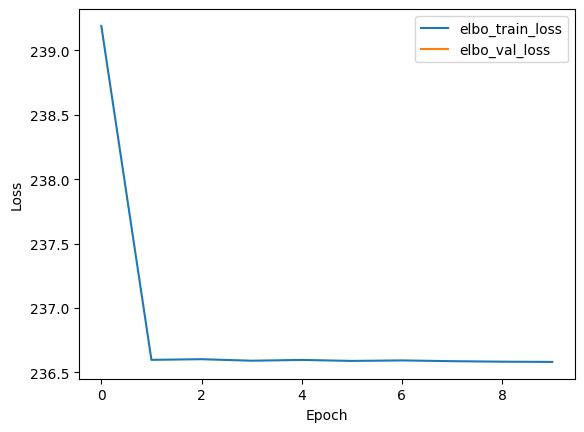

In [10]:
if train_save:
    vae.plot_loss()

## Create LSTM data and model

In [11]:
encoded_training_data = vae.encode_data(train_loader)

In [12]:
print(encoded_training_data.shape)

(110048, 6)


In [13]:
# Create a DataLoader object
lstm_dataloader = DataLoaderGenerator(encoded_training_data, batch_size=32)
#train_loader_lstm, val_loader_lstm = lstm_dataloader.generate()
train_loader_lstm = lstm_dataloader.generate()

In [14]:
train_loader_lstm.dataset.tensors[0].shape

torch.Size([110048, 1, 6])

In [15]:
from Utils.models import LSTM
from torchinfo import summary as summary2

lstm = LSTM()
lstm = lstm.to('cuda')
print(lstm)
summary2(lstm, input_size=(1, 6))

LSTM(
  (models): ModuleList(
    (0): LSTM(6, 64, batch_first=True)
    (1): LSTM(64, 64, batch_first=True)
    (2): LSTM(64, 6, batch_first=True)
    (3): Linear(in_features=6, out_features=6, bias=True)
  )
)


Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [1, 6]                    --
├─ModuleList: 1-1                        --                        42
│    └─LSTM: 2-1                         [1, 64]                   18,432
│    └─LSTM: 2-2                         [1, 64]                   33,280
│    └─LSTM: 2-3                         [1, 6]                    1,728
Total params: 53,482
Trainable params: 53,482
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.32
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.21
Estimated Total Size (MB): 0.21

## Train LSTM

In [17]:
train_save = True
if train_save:
    # Train the model
    lstm.train_model(train_loader_lstm, n_epochs=10)
    # Save the model
    lstm.save_model("Weights/lstm.pth")
else:
    # Load the model
    lstm.load_model("Weights/lstm.pth")
    lstm.eval()

Epoch 1/10, Loss: 38.76661682128906
Epoch 2/10, Loss: 47.334251403808594
Epoch 3/10, Loss: 53.1032829284668
Epoch 4/10, Loss: 51.886802673339844
Epoch 5/10, Loss: 52.67978286743164
Epoch 6/10, Loss: 44.86387634277344
Epoch 7/10, Loss: 56.80243682861328
Epoch 8/10, Loss: 56.61362075805664
Epoch 9/10, Loss: 49.10042953491211
Epoch 10/10, Loss: 61.88829803466797


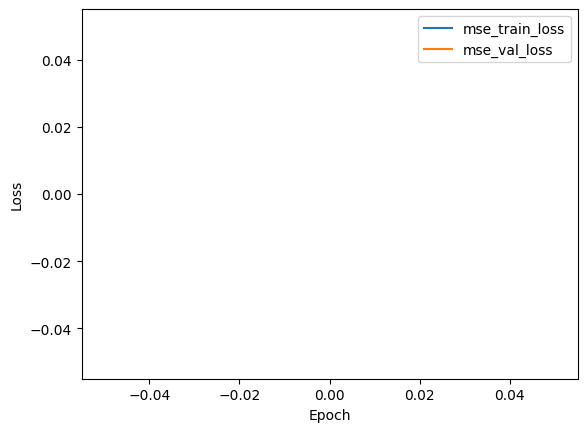

In [20]:
if train_save:
    lstm.plot_loss()

## Evaluate VAE-LSTM Model

In [ ]:
from Utils.models import VAE_LSTM

vae_lstm = VAE_LSTM(vae, lstm)
#vae_lstm.evaluate(test_loader, 0.9)